# Assignment 4: Hough Transform

## Ex. 4.1 Detect lanes and eyes

* there are two datasets available: "images/eye_tracking" and "images/lane_detection" - decide for one of them
* implement the classical Hough Transform for lines (for lane detection) **OR** circles (eye tracking) as shown in the lecture
* use a Canny edge detector to produce edge images for the sequence of images

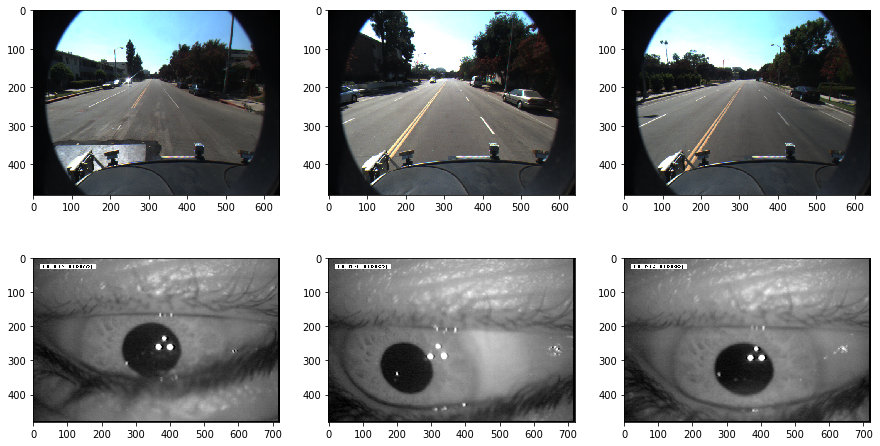

In [4]:
%matplotlib inline 
import matplotlib.pyplot as plt
from skimage import io, data, feature, color
import numpy as np

lane1 = io.imread('images/lane_detection/f00000.png')
lane2 = io.imread('images/lane_detection/f00050.png')
lane3 = io.imread('images/lane_detection/f00090.png')

eye1 = io.imread('images/eye_tracking/0000.jpeg')
eye2 = io.imread('images/eye_tracking/0050.jpeg')
eye3 = io.imread('images/eye_tracking/0090.jpeg')

fig = plt.figure(figsize=(15, 8))
ax11 = plt.subplot(2, 3, 1)
ax12 = plt.subplot(2, 3, 2)
ax13 = plt.subplot(2, 3, 3)
ax21 = plt.subplot(2, 3, 4)
ax22 = plt.subplot(2, 3, 5)
ax23 = plt.subplot(2, 3, 6)


ax11.imshow(lane1)
ax12.imshow(lane2)
ax13.imshow(lane3)

ax21.imshow(eye1)
ax22.imshow(eye2)
ax23.imshow(eye3)

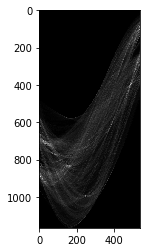

In [183]:
from skimage.feature import canny
from skimage.color import rgb2gray


NUM_DISCRETE_ANGLES = 3 * 180


def get_accumulator(img, *, n_discrete_angles=180, canny_kwargs={}):
    gray_img = rgb2gray(img)
    edge_img = canny(gray_img, **canny_kwargs).astype(np.int)
    
    angles = np.linspace(0, np.pi, num=n_discrete_angles, endpoint=True)
    rr, cc = np.where(edge_img == True)
    
    # Precompute 'cos' and 'sin' for all discrete angles.
    angle_matrix = np.array([np.cos(angles), np.sin(angles)])
    indices = np.array([rr, cc]).T
    # print(indices.shape, '×', angle_matrix.shape, '=', (indices @ angle_matrix).shape)
    
    # Matrix of all values for 'r' as ints so they can be used as indices for 'A'.
    R = np.round(indices @ angle_matrix).astype(np.int)
    
    # 'r' can be negative (e.g. (x=1, y=1), a=179° => r = cos(179) + sin(179) < 0)
    # Since we always have all angles from 0 - 180 degrees and most likely at least 1 pixel, 
    # the above scenario will most certainly happen. Thus we can assume that 'min_r' is negative.
    # We also set the size of 'A' (for 'r') dynamically instead using 2*sqrt(width**2 + height**2)
    # in order to reduce the accumulator size (=> performance).
    min_r, max_r = np.min(R), np.max(R)
    offset_r = -min_r
    # NOTE: +1 for the zero.
    A = np.zeros((max_r + offset_r + 1, len(angles)))
    
    for angle_index in range(0, R.shape[1]):
        # Count occurences of distinct values of 'r' for each column (== discrete angle).
        r_s, counts = np.unique(R[:, angle_index], return_counts=True, axis=0)
        a_s = np.repeat(angle_index, r_s.shape[0])
        A[r_s + offset_r, a_s] = counts
    return A


acc = get_accumulator(lane1, n_discrete_angles=NUM_DISCRETE_ANGLES, canny_kwargs=dict(sigma=1.7))
plt.imshow(acc, cmap='gray')


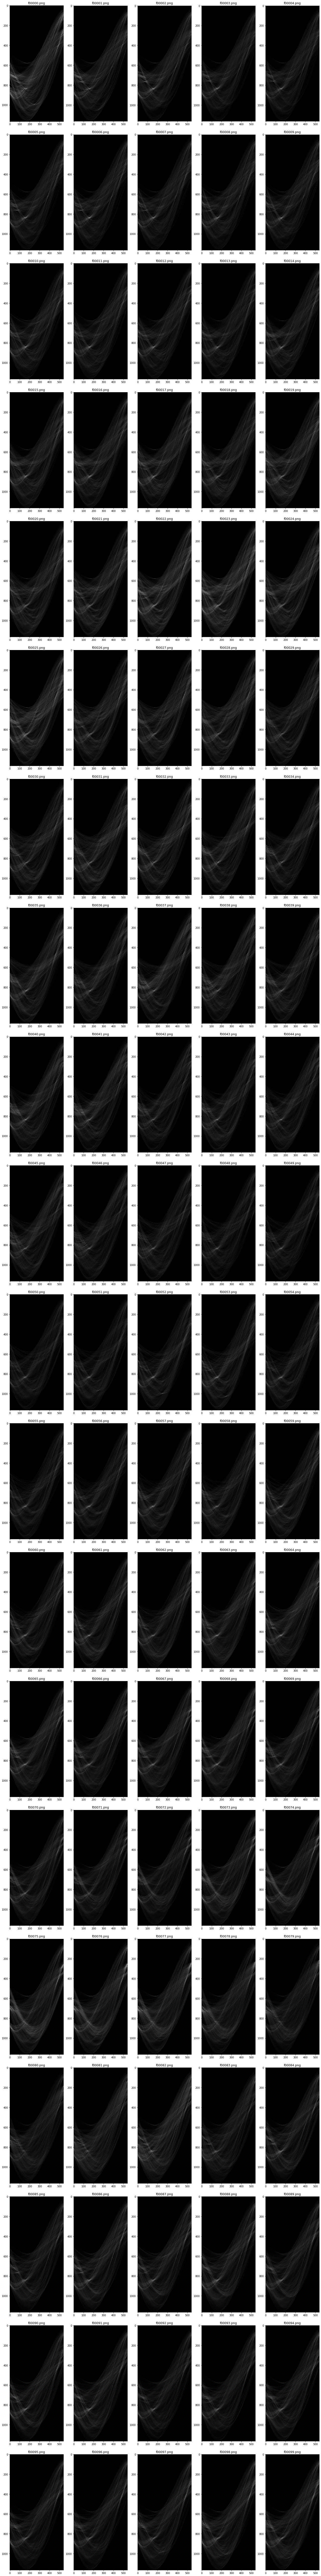

In [163]:
from math import ceil
from multiprocessing import Pool


def _get_acc(frame):
    return get_accumulator(frame, discretes_per_degree=NUM_DISCRETE_ANGLES, canny_kwargs=dict(sigma=1.7))


frames = io.imread_collection("images/lane_detection/*")
pool = Pool()
accs = pool.map(_get_acc, frames)

N = len(accs)
NCOLS = 5
NROWS = ceil(N / NCOLS)
fig, axes = plt.subplots(
    nrows=NROWS,
    ncols=NCOLS,
)
f = 3.6
fig.set_figwidth(f*NCOLS)
fig.set_figheight(f*NROWS*2)

plt.subplots_adjust(wspace = .01)
fig.tight_layout()
axes = np.asarray(axes).ravel()
for i, acc in enumerate(accs):
    axes[i].imshow(acc, cmap='gray')
    axes[i].set_title(f'f000{i:02}.png')
    

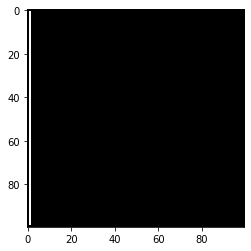

In [177]:
# dieser Code wurde als Musterlösung von Sebastian Oltmanns zur Verfügung gestellt und von Tim renoviert

%matplotlib inline
from skimage.draw import line
from skimage import io
import math
import numpy as np

def draw_line_hessian_normal(image, a, r, color=1):
    dimy, dimx = image.shape[:2]

    #r = x*cosa + y*sina

    rad = math.radians(a)
    cos = math.cos(rad)
    # Prevent division by zero.
    sin = math.sin(rad) or 1e-4
    
    
    # compute start and end point of line 
    x0 = 0
    y0 = round((r - x0*cos) / sin)
    x1 = dimx
    y1 = round((r - x1*cos) / sin)

    liney,linex = line(y0,x0,y1,x1)
    
    ret = np.copy(image)
    for yy in range(0,liney.size-1):
        if (liney[yy] > 0) and (liney[yy] < dimy-1):
            ret[liney[yy],linex[yy]] = color
    return ret

image = np.zeros((100,100))
# image = draw_line_hessian_normal(image, 20, 60)
# image = draw_line_hessian_normal(image, 20, 10)
# image = draw_line_hessian_normal(image, 110, 0)
# image = draw_line_hessian_normal(image, -70, 10)
# image = draw_line_hessian_normal(image, 135, -20)
image = draw_line_hessian_normal(image, 0.1, 1)
plt.imshow(image, cmap='gray')

## OPTION 1: line detection for lane detection 

* use your implementation of the Hough Transform to find the 10 strongest lines in the image
* display your result set (draw those lines on the image) (**RESULT**)
* can you improve the performance by limiting the space of solutions? implement and draw lines again! (**BONUS**)

[(899, 17), (902, 19), (831, 3), (903, 20), (830, 2), (717, 41), (108, 529), (717, 40), (90, 536), (92, 535)]

[(903, 20), (892, 9), (766, 77), (770, 76), (837, 172), (770, 78), (770, 77), (723, 42), (766, 76), (832, 161)]

[(835, 162), (618, 384), (838, 170), (833, 159), (832, 160), (768, 74), (620, 385), (764, 74), (621, 383), (838, 169)]

[(831, 155), (619, 386), (830, 157), (625, 384), (626, 382), (836, 167), (622, 385), (623, 383), (831, 156), (836, 168)]

[(834, 160), (836, 163), (627, 381), (759, 71), (623, 384), (838, 167), (624, 382), (832, 156), (626, 383), (837, 168)]

[(623, 382), (622, 384), (835, 160), (834, 155), (834, 154), (626, 381), (833, 156), (839, 167), (625, 383), (838, 168)]



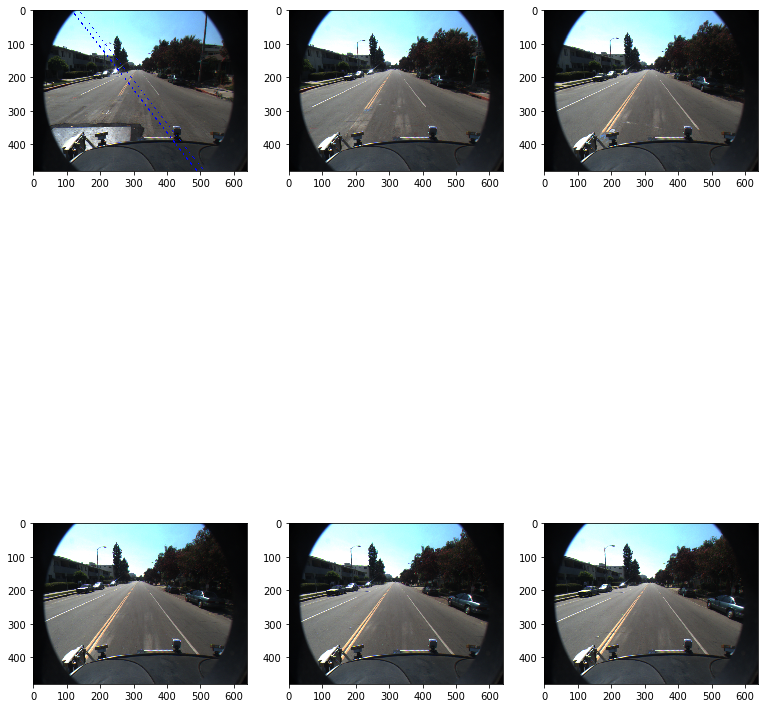

In [187]:
from math import degrees


def top_n_indexes(arr, n):
    """See https://gist.github.com/tomerfiliba/3698403"""
    idx = np.argpartition(arr, arr.size - n, axis=None)[-n:]
    width = arr.shape[1]
    return [divmod(i, width) for i in idx]


_accs = accs[:6]
N = len(_accs)
NCOLS = 3
NROWS = ceil(N / NCOLS)
fig, axes = plt.subplots(
    nrows=NROWS,
    ncols=NCOLS,
)
f = 3.6
fig.set_figwidth(f*NCOLS)
fig.set_figheight(f*NROWS*2)
plt.subplots_adjust(wspace = .01)
fig.tight_layout()
axes = np.asarray(axes).ravel()

# frames_with_lines = []
line_color = np.array([0, 0, 255])
for i, acc in enumerate(_accs):
    top_indices = top_n_indexes(acc, n=10)
    print(top_indices, end='\n\n')
#     img = rgb2gray(frames[i])
    img = frames[i]
    for index in top_indices:
        r, angle_index = index
        img = draw_line_hessian_normal(img, int(degrees(a)), int(r), line_color)
    axes[i].imshow(img)
#     axes[i].set_title(f'f000{i:02}.png')
#     frames_with_lines.append(img)

# io.imshow_collection(frames_with_lines)

None

## OPTION 2: circle detection for eye detection
* use your implementation of the Hough Transform to find the 10 strongest circles in the image
* display your result set (draw those circles on the image) (**RESULT**)
* can you improve the performance by limiting the space of solutions? implement and draw circles again! (**BONUS**)

In [ ]:
None

# Ex. 4.2 Generalized Hough Transform

* implement the Generalized Hough Transform as described in the lecture for localizing a given template
* find the given template (see below) and mark its location in the image "animals.png" (**RESULT**)

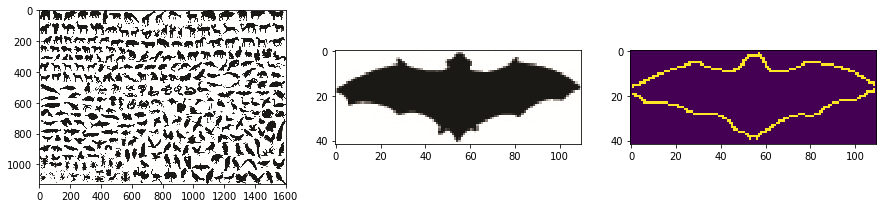

In [9]:
%matplotlib inline 
import matplotlib.pyplot as plt
from skimage import io, data, feature, color
import numpy as np

animals = io.imread('images/animals.png')

xmin = 1271
xmax = 1381
ymin = 519
ymax = 561

bat = animals[ymin:ymax, xmin:xmax]
bat_edge = feature.canny(color.rgb2gray(bat), 2)

fig = plt.figure(figsize=(15, 10))
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2)
ax3 = plt.subplot(1, 3, 3)

ax1.imshow(animals)
ax2.imshow(bat)
ax3.imshow(bat_edge)

## BONUS 
* now implement an extended version of the GHT that find rotated and scaled variants of the template. 
* find Italy (see "italy.jpg") and the map of Europe ("europe_map_political.gif")
* note that you can binarize your italy template by using a simple color lookup
* draw the location of italy on the map and print its scale and orientation (**BONUS**)